# TODO:
MLP
- Data analysis
- Data preprocessing and normalization
- Data split
- Configuration
- Experiment tracking
- Experiments - meaningful based on the results of previous experiments
    - Including improvement techniques (e.g. Dropout, Normalization layers, Skip
    Connections, Bottleneck Layers, …)
- Hyperparameter search (grid/random) / sweep     #optional
- Results and evaluation metrics
- Clear code
- Markdown documentation and comments
- Final presentation of projects
- Effort on consultations


# OUR TODO:
- download dataset using pandas ? easier because of we can just use link but maybe everyone will use pandas -done
- good enough data analysis that is seen in jupyter notebook, not just from reading dataset - done
- correlation chart  -  chart of correlation of columns between themselves - done
- outliers - what to do with them ? 
- counts of data in each column and plots of them -done

<!-- - normalize age 0-1 young/old ? min max alebo z score, maju 0 alebo odchylka ma 1 -->
- normalize age 0-1 young/old ? min max or z score, mean have 0 deviation has 1
- warning if something has 100% correlation we should do something with it
- better -1 is False; 0 - not state /dont know; 1 - True
- think about combining weird features 
- or if 20% are not state try to remove them
- vantby tracking experiments
- focus on binary prediction with binary cross entropy on only testing   (zamerane na binarnu predikciu binary cross entropy na testovacej dat metriky netrenujem )
- datasplit for training validation and testing DF 70 10 20 and check if decreasing both training and validation loss

imports

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

# Dataset

In [93]:


df = pd.read_csv("dataset.csv")

print("Shape of dataset:", df.shape)
display(df.head())

numeric_df = df.select_dtypes(include=["number"])

Shape of dataset: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Data analysis with nice graphs and chart of correlations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

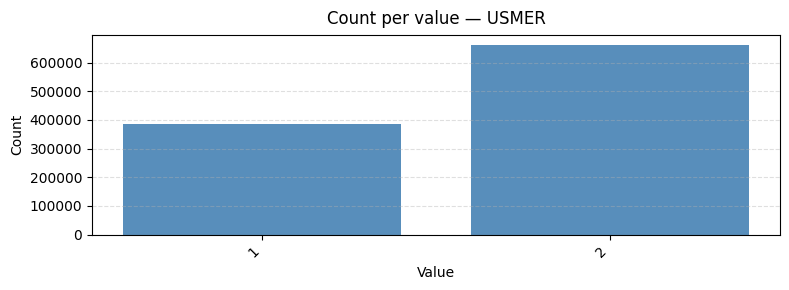

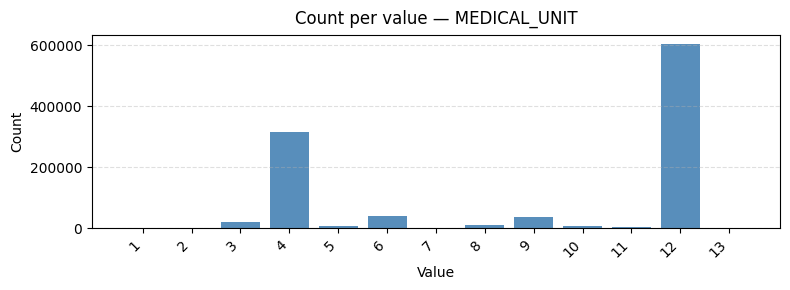

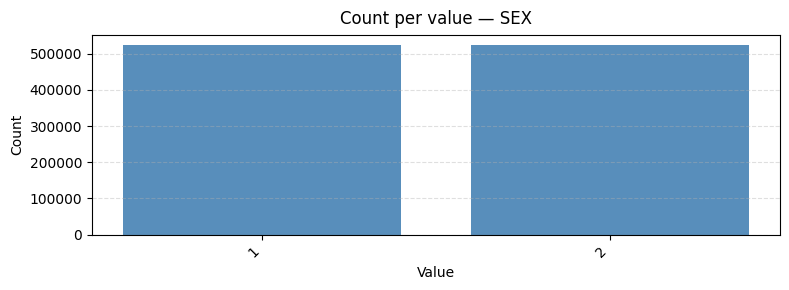

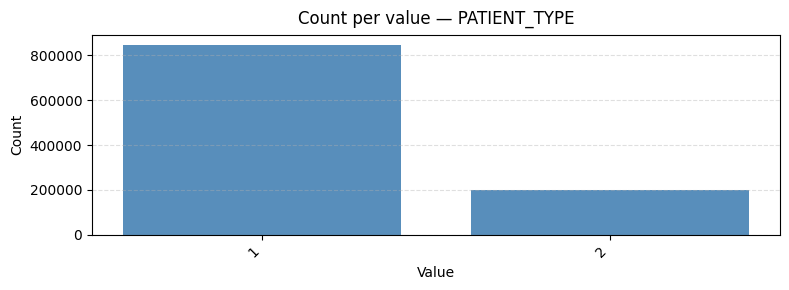

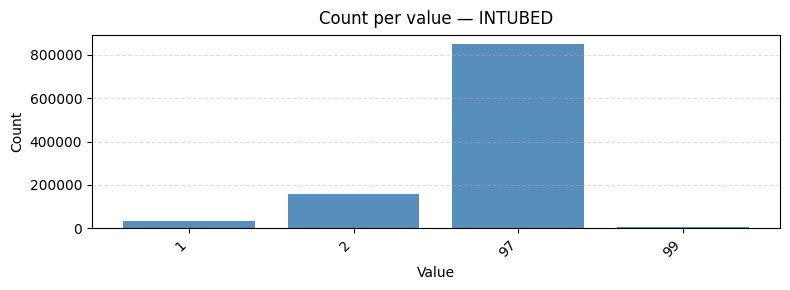

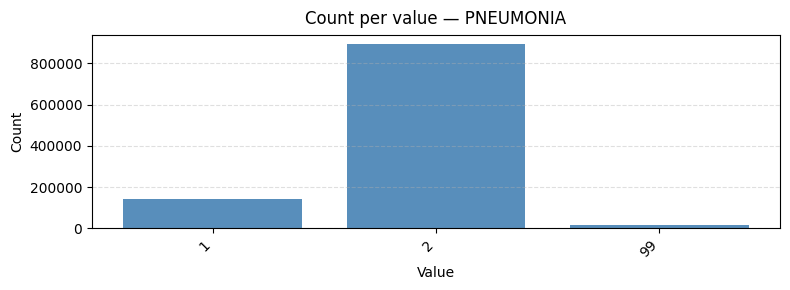

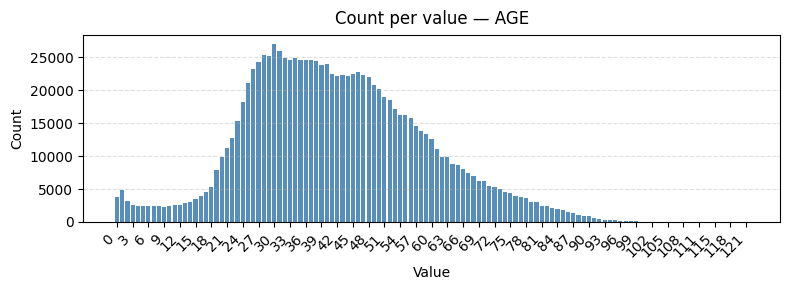

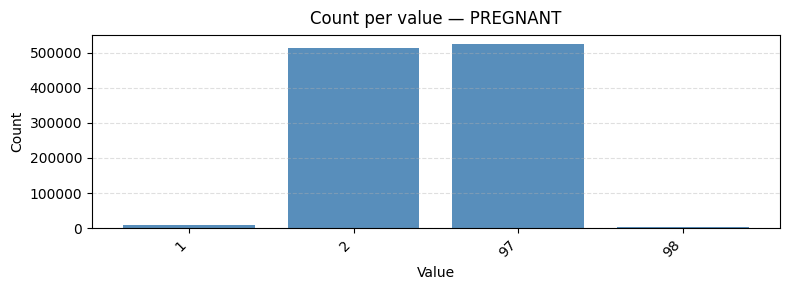

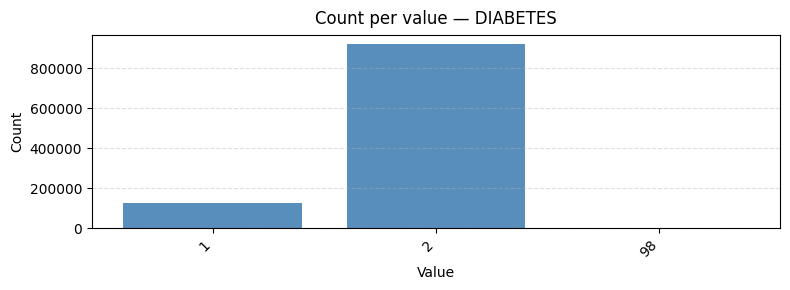

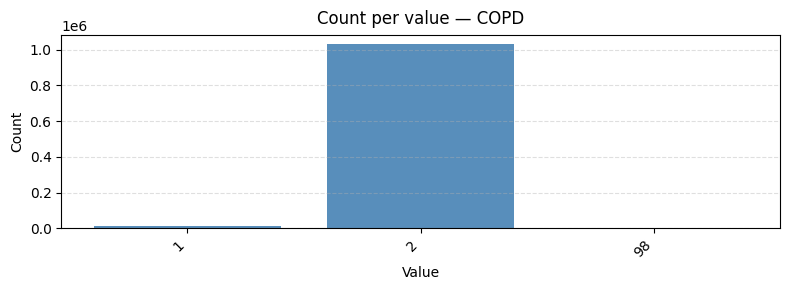

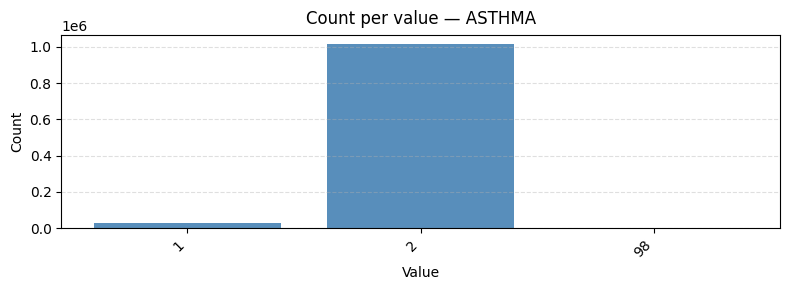

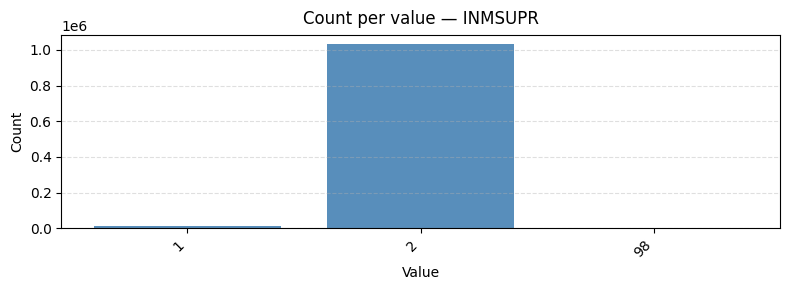

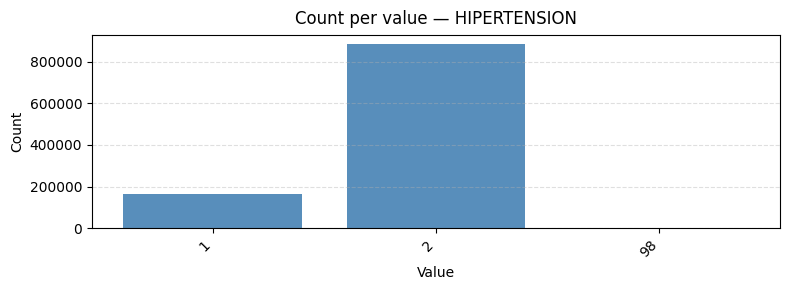

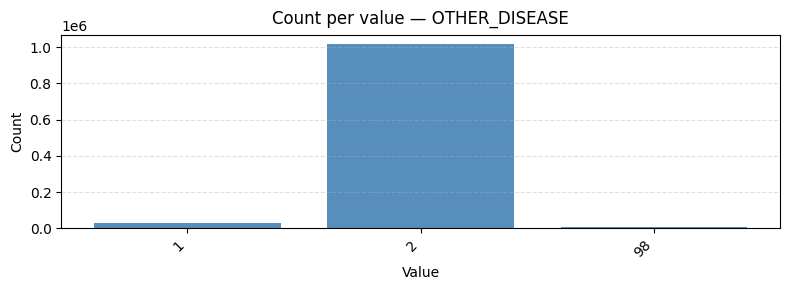

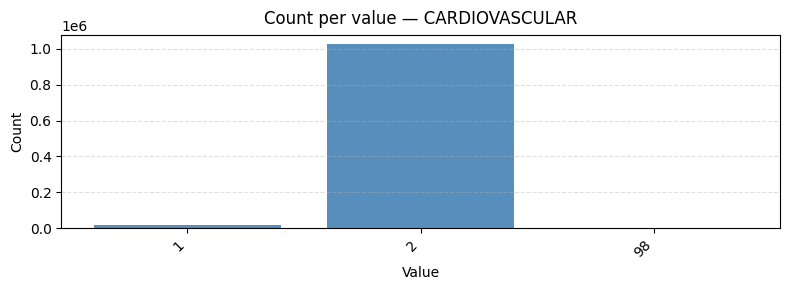

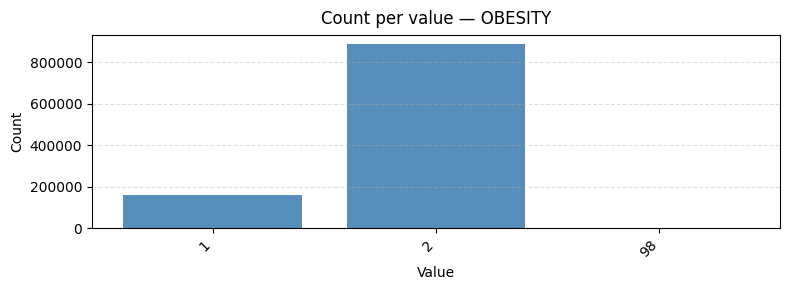

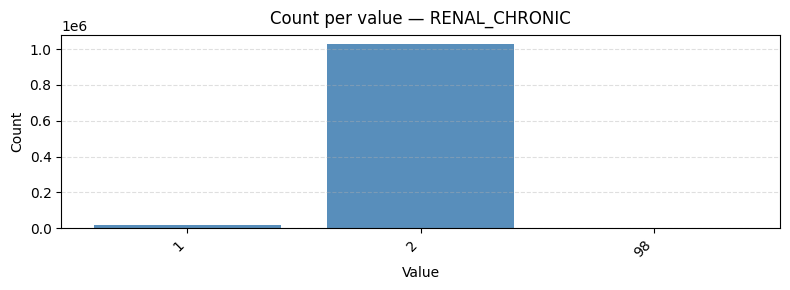

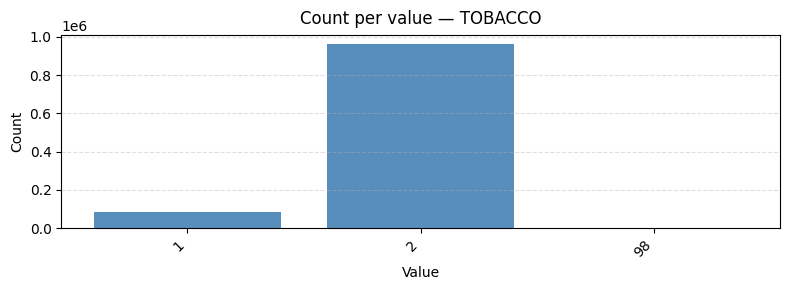

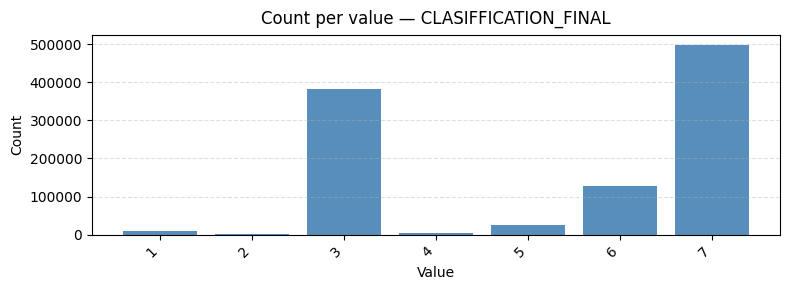

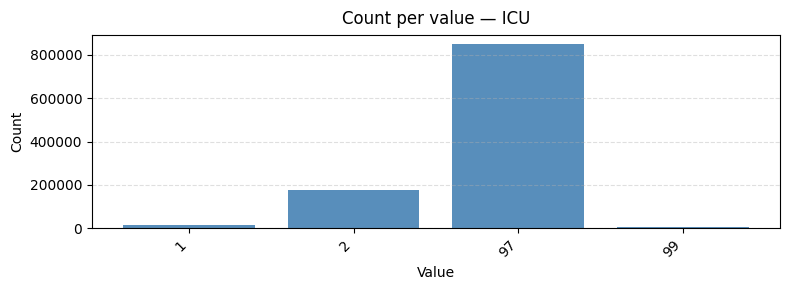

In [94]:
df.info()

df.count(numeric_only=True)
print("Dataset shape: ", df.shape)

for col in numeric_df.columns:
    s = numeric_df[col]

    # Drop NaNs for clean counts
    counts = s.value_counts(dropna=False).sort_index()

    # X are just sequential positions (0,1,2,...)
    x = range(len(counts))
    y = counts.values
    labels = counts.index.astype(str)

    plt.figure(figsize=(8, 3))
    plt.bar(x, y, color="steelblue", alpha=0.9, width=0.8)
    plt.title(f"Count per value — {col}", fontsize=12, pad=8)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", axis="y", alpha=0.4)

    # Show real values as x-tick labels (compressed)
    if len(labels) > 40:
        step = max(1, len(labels) // 40)
        plt.xticks(x[::step], labels[::step], rotation=45, ha="right")
    else:
        plt.xticks(x, labels, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

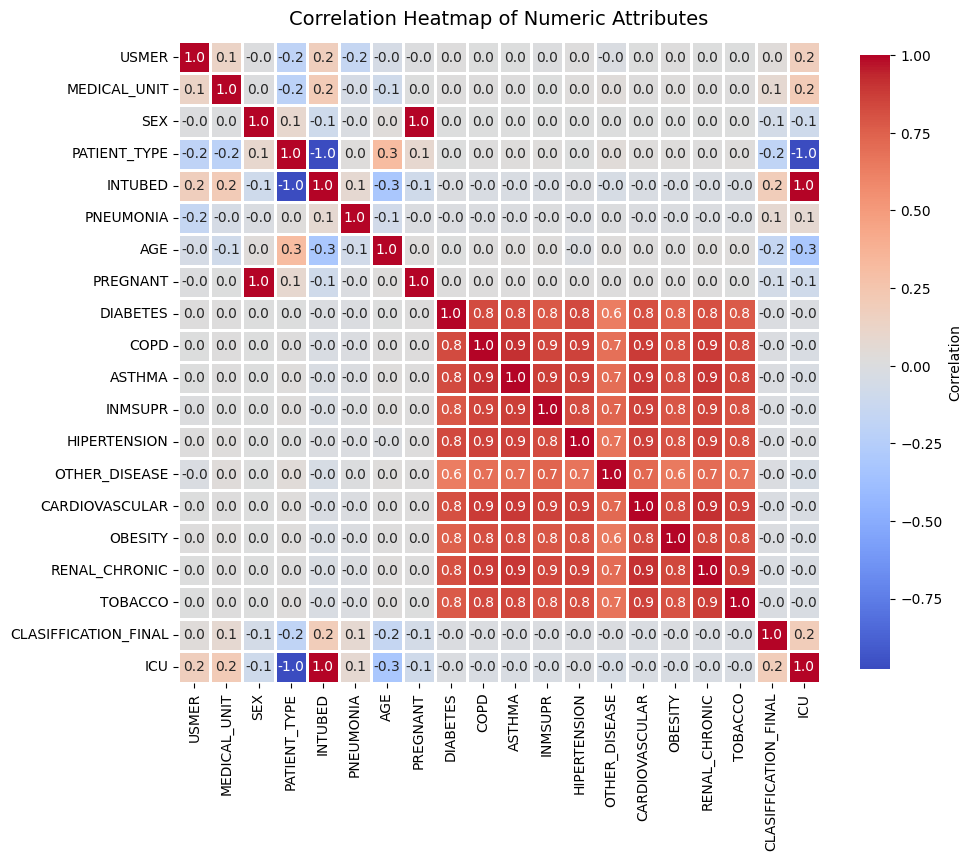

In [95]:

corr = numeric_df.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(
    corr,
    annot=True,         # Show correlation values
    cmap="coolwarm",    # Color palette
    fmt=".1f",          # Format numbers to 1
    square=True,        # Make cells square
    linewidths=1,       # Add thin lines between cells
    cbar_kws={"shrink": 0.7, "label": "Correlation"}
)

plt.title("Correlation Heatmap of Numeric Attributes", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# Data preprocessing and normalization

## Probably normalize like this: 
    - date_died change from date and 9999-99-99 with 1-died 0-alive ?? maybe 
    - pregnant men don't exist, either leave 97 as NA for column pregnant for men or normalize and set it to 0

In [96]:
print("Shape of dataset:", df.shape)
df.rename(columns={"DATE_DIED": "DEAD"}, inplace=True)
print("Before changes")
display(df.iloc[0:31])

med_unit_original = df["MEDICAL_UNIT"].copy()
classif_original = df["CLASIFFICATION_FINAL"].copy()

df["DEAD"] = np.where(df["DEAD"] == "9999-99-99", 2, 1)
df.loc[df["SEX"] == 1, "PREGNANT"] = -1

df = df.replace(2, -1)
df = df.replace(97, 0)
df = df.replace(98, 0)
# Restore original columns which are not binary
df["MEDICAL_UNIT"] = med_unit_original
df["CLASIFFICATION_FINAL"] = classif_original

df.rename(columns={"SEX": "IS_MALE"}, inplace=True)
# CLASSIFICATION FINAL TO BINARY 1,2,3 COVID, 4+ NO COVID
df.CLASIFFICATION_FINAL = df.CLASIFFICATION_FINAL.replace([1,2,3], 1)
df.CLASIFFICATION_FINAL = df.CLASIFFICATION_FINAL.replace([4,5,6,7], -1)
df.rename(columns={"CLASIFFICATION_FINAL": "HAS_COVID"}, inplace=True)
print("After changes")
display(df.iloc[3:31])


Shape of dataset: (1048575, 21)
Before changes


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DEAD,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


After changes


,USMER,MEDICAL_UNIT,IS_MALE,PATIENT_TYPE,DEAD,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,HAS_COVID,ICU
3,-1,1,1,1,1,0,-1,53,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
4,-1,1,-1,1,1,0,-1,68,0,1,...,-1,-1,1,-1,-1,-1,-1,-1,1,0
5,-1,1,1,-1,-1,-1,1,40,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
6,-1,1,1,1,-1,0,-1,64,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,0
7,-1,1,1,1,-1,0,1,64,-1,1,...,-1,1,1,-1,-1,-1,1,-1,1,0
8,-1,1,1,-1,-1,-1,-1,37,-1,1,...,-1,-1,1,-1,-1,1,-1,-1,1,-1
9,-1,1,1,-1,-1,-1,-1,25,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
10,-1,1,1,1,-1,0,-1,38,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,0
11,-1,1,-1,-1,-1,-1,-1,24,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
12,-1,1,-1,-1,-1,-1,-1,30,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


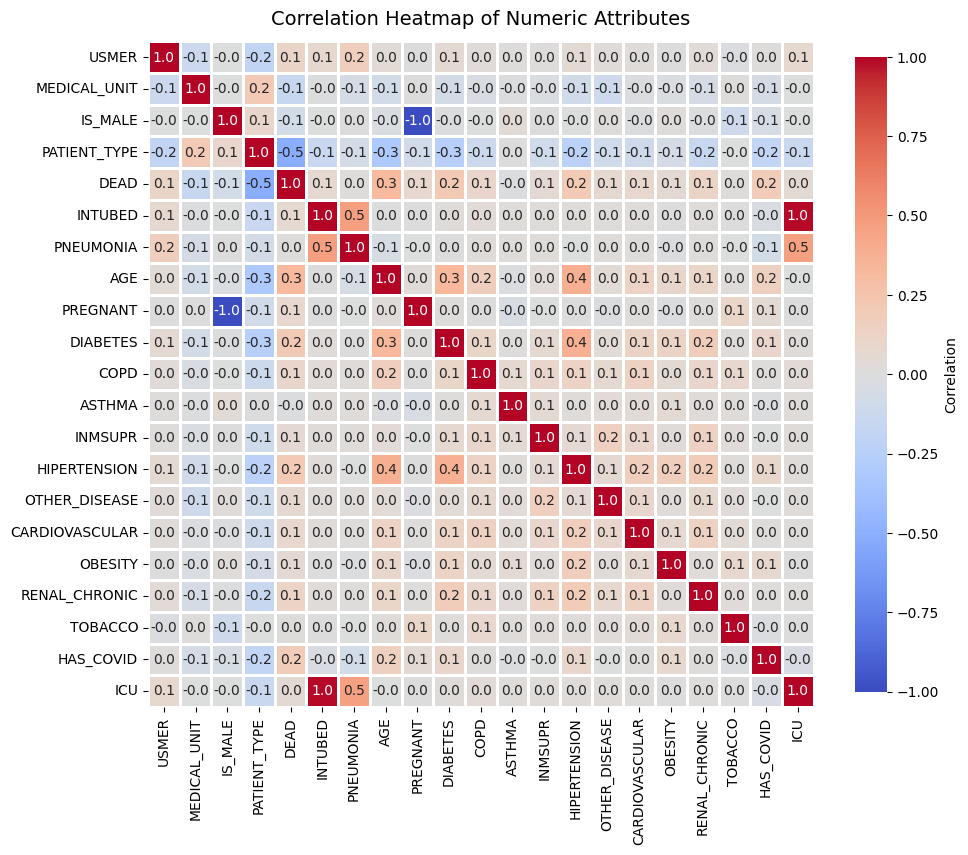

In [97]:
numeric_df = df.select_dtypes(include=["number"])
corr = numeric_df.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(
    corr,
    annot=True,         # Show correlation values
    cmap="coolwarm",    # Color palette
    fmt=".1f",          # Format numbers to 1
    square=True,        # Make cells square
    linewidths=1,       # Add thin lines between cells
    cbar_kws={"shrink": 0.7, "label": "Correlation"}
)

plt.title("Correlation Heatmap of Numeric Attributes", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

## Datasplit

Splitting the dataset 80% to 20%. 80% of dataset will be used for training and the 20% will be used for testing the trainged neural network

In [ ]:
#calculating the 80%
training_percentage = 0.7
validation_percentage = 0.1
training_part = int(df.shape[0]*training_percentage)
validation_part = training_part + int(df.shape[0]*validation_percentage)

#deviding the base data frame to two
training_df = df[0:training_part]
validation_df = df[training_part:validation_part]
testing_df = df[validation_part:]
print("Traing DF shape: ", training_df.shape,"\nValidation DF shape: ", validation_df.shape, "\nTesting DF shape: ",testing_df.shape, f"\nDataset is divided {training_percentage*100}% for training, {validation_percentage*100}% for validation and {round((1-training_percentage-validation_percentage)*100,0)}% for testing")

#seting dataset to contain only numeric values just for now, later delete probably
# training_df = training_df.select_dtypes(include=["number"])
# testing_df = testing_df.select_dtypes(include=["number"])


Traing DF shape:  (734002, 21) 
Validation DF shape:  (104857, 21) 
Testing DF shape:  (209716, 21) 
Dataset is divided 70.0% for training, 10.0 for validation and 20.0% for testing


## Configuration

Creating a config dictionary - easy to modify

In [99]:
MLP_config = {
    "features_X": ["DIABETES", "ASTHMA", "ICU", "INTUBED"],  ## add more 
    "layers": [],
    "output_size": 1,
    "hidden_size": 10
}

MLP_config["input_size"] = len(MLP_config["features_X"])

## Defining our Model with PyTorch 


In [100]:
## Model 

class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.layers = [
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.Linear(hidden_size, output_size)
            ]
        self.activation = torch.nn.Sigmoid()

    def forward(self, input) -> np.ndarray:
        output = self.activation(self.layers[0](input))
        output = self.layers[1](output)
        print(output.shape)
        return output

    def backward(self, dz: np.ndarray):
        
        return dz

In [101]:
#initializing features needed for the MLP
dataset_features_X = torch.tensor(np.transpose(training_df[MLP_config["features_X"]].values))
dataset_labels_Y = torch.tensor(np.transpose(training_df[["HAS_COVID"]].values[:4])).float().view(-1,1)
# y = torch.tensor(df["HAS_COVID"].values[:4]).float().view(-1, 1)
# check the shape, if correct, let the np.transpose() if not, delete it
print(dataset_features_X.shape, dataset_labels_Y.shape) 

torch.Size([4, 734002]) torch.Size([4, 1])


In [102]:
#initialize MLP
# print(MLP_config)
MLP = Model(len(training_df[MLP_config["features_X"]]), MLP_config["hidden_size"], MLP_config["output_size"])
# print(dataset_features_X, "\n", torch.tensor(dataset_features_X).to(torch.float32))
Y_hat = MLP.forward(torch.tensor(dataset_features_X).to(torch.float32))
print(Y_hat)


torch.Size([4, 1])
tensor([[-0.1193],
        [-0.1269],
        [-0.8918],
        [-0.8861]], grad_fn=<AddmmBackward0>)


C:\Users\adamg\AppData\Local\Temp\ipykernel_25744\3515552011.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_hat = MLP.forward(torch.tensor(dataset_features_X).to(torch.float32))


In [103]:
# Calculate loss  
LOSS = torch.nn.BCELoss()   

da = LOSS(Y_hat, dataset_labels_Y)

backward_output = MLP.backward(da)

for i in range(len(MLP_config["features_X"])):
    print(f"{MLP_config["features_X"][i]} {backward_output.mean()} - {backward_output}")
    



RuntimeError: all elements of input should be between 0 and 1